Some initial imports

In [1]:
from pygom import common_models

from pygom import SimulateOde, Transition, ODEVariable, DeterministicOde

import numpy 

In [ ]:
Basic setting up of model without Kalman Filter. So, in this formulation beta is a parameter, not a variable

In [2]:
import scipy.stats
state_list = ['S', 'I', 'R']
param_list = ['beta', 'gamma','N']
transition_list = [
                  Transition(origin='S', destination='I', equation='beta*S*I/N', transition_type="T"),
                  Transition(origin='I', destination='R', equation='gamma*I', transition_type="T")
                 ]

d = dict()
d['beta']  = 1.8
d['gamma'] = 0.2
d['N']     = 1000

t1 = 100
N = 1000

x0=  [ 900.0  , 100.0  ,  0.0]
dt=0.25
x=[x0]
t0 = 0

Create a determinstic model from the paramters above.This will be used to create observations with a known beta (1.8 in the above)

In [3]:
states = ['S','I','R']
extended_ode_deterministic= DeterministicOde(states, d, transition=transition_list)
extended_ode_deterministic.parameters =d
t=t0


In [4]:
#create output with known beta value
t = numpy.linspace(t0, 100, 1000)
extended_ode_deterministic.initial_values = (x0, t[0])
# create a lsit of observations
Outputs = extended_ode_deterministic.integrate(t)

These outpputs will be used to create "observations" for a second run which this time will have beta as a variable, and will have a Kalman Filter applied


In [5]:
# now enter these outputs as observations
observations= [Output[1] for Output in Outputs]
observations =observations[2:]
t =t[:len(observations)]
observed_states =[1]

#observations = observations.tolist()
# set everything up again ,but this time with beta as a variable
transition_list = [
                  Transition(origin='S', destination='I', equation='beta*S*I/N', transition_type="T"),
                  Transition(origin='I', destination='R', equation='gamma*I', transition_type="T")
                 ]

d = dict()

d['gamma'] = 0.2
d['N']     = 1000

t1 = 100
N = 1000
# beta is the 4th item in the state list. The line below implies that beta is starting from
# a value of 10.0 . The true value used to create the input data is 1.8
x0=  [ 900.0  , 100.0  ,  0.0,10]
dt=0.25
x=[x0]
t0 = 0

Now  run model with parameters above with Kalamn Filter integration 

In [7]:
states = ['S','I','R','beta']
extended_ode_deterministic_beta= DeterministicOde(states, d, transition=transition_list)
extended_ode_deterministic_beta.parameters =d
#indices of states whcih are being observed
observed_states =[1]
sigmap2 =10.0
sigmaw2 =1.0
sigmar2 =1.0
# Integrate the equation again ,this time with the Kalman Filter applied 
# The additional input arguments for the IntegrateWithKalamnFilter routine are:
# list of observations
# Indices of observed states
# The three Noise variances
# Index of the beta value in the list of variables
#
# The 3 variances are
# 'p' the starting value for the posteriori estimate covariance matrix 
# 'w' the process noise
# 'r' the observation noise
Outputs_beta =extended_ode_deterministic_beta.IntegrateWithKalmanFilter(extended_ode_deterministic_beta,x0,t, observations, observed_states, sigmap2,sigmaw2,sigmar2,beta_state=3)

As beta is the last of the variables, extract the last item from the output of the Kalman filtered run and plot it.
The true value used ot create the observations is 1.8, and the KF run started from an assumed vale of 10.0 .So thr graph should start higher, but  should eventually converge to 1.8

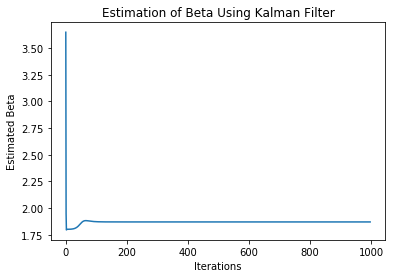

In [12]:
import matplotlib.pyplot as plt
## Extract the estimated beta values, iteration by iteration, from the most recent run output
beta_values=[]

for i in range(len(Outputs_beta)):
    beta_values.append(Outputs_beta[i][-1])
# Plot beta value - estimates are expected to converge on value of 1.8 as that was the true value used to 
# generate the input observations
plt.plot(beta_values)

plt.ylabel("Estimated Beta")
plt.xlabel("Iterations")
plt.title("Estimation of Beta Using Kalman Filter")
plt.show(block=False)